In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [4]:
code_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/code_reg_and_clas"
import os, sys
if code_dir not in sys.path:
    sys.path.append(code_dir)

plots the percentage of points (vertical axis) for which predicted scene coordinates reside within a given distance (horizontal axis) from a corresponding ground truth location


**TODO:**
* for each model get predictions on validation dataset
* for each model's predictions -> get the MSE error to GT
* sort
* get MSE error at 1-to-100th percentile. 1-to-100 on y-axis; coresponding MSE values on x-axis

# Load validation data

In [11]:
def get_data_partition(model_dir):
    # load json with data split
    data_partition_path = model_dir + "/data_partition.json"

    data_partition_file = open(data_partition_path)
    data_partition = json.load(data_partition_file)
    data_partition_file.close()
    
    return data_partition

In [19]:
def load_validation_images(model_dir, simple_whitenning=False):
    
    data_partition = get_data_partition(model_dir)
    dataset_size = len(data_partition['validation'])
    
    images = np.zeros((dataset_size, 256, 512, 3))
    oracle_global_coords = np.zeros((dataset_size, 256, 512, 3))
    regions = np.zeros((dataset_size, 256, 512, 1))
    local_coords = np.zeros((dataset_size, 256, 512, 3))
    masks = np.zeros((dataset_size, 256, 512, 1))

    dataset = {}
    for i, data_dir in enumerate(data_partition['validation']):
        data = np.load(data_dir)
        

        images[i] = data['image_colors']
        oracle_global_coords[i] = data['points_3d_world']
        regions[i,:,:,0] = data['points_region_class']
        local_coords[i] = data['local_scene_coords']
        masks[i,:,:,0] = data['mask']
        
        if i == 0:
            if not simple_whitenning:
                dataset['W_inv'] = data['W_inv']
                dataset['M'] = data['M']
                dataset['std'] = data['std']
            else:
                dataset['M'] = data['mean_vec']
                dataset['std'] = data['std_vec']
                
    dataset['images'] = images
    dataset['oracle_global_coords'] = oracle_global_coords
    dataset['regions'] = regions
    dataset['local_coords'] = local_coords
    dataset['masks'] = masks
    
    return dataset

# Load model and make predictions

In [20]:
from utilis.experiment_utilis import combined_loss_weighted
import tensorflow as tf
from tensorflow import keras 

def load_model(model_dir):
    # load model
    checkpoint_dir = model_dir + "/saved_model/my_model"
    model = keras.models.load_model(checkpoint_dir, compile=False)
    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=combined_loss_weighted([10, 1]))
    
    return model

def predict(model, images, masks):
    dataset_size = len(images)
    pred_local_coords = np.zeros((dataset_size, 256, 512, 144))
    for i in tqdm(range(dataset_size)):
        pred_local_coords[i] = np.array(model.predict_on_batch([images[i:i+1], masks[i:i+1]]))
    
    return pred_local_coords

def unwhitten(pred_local_coords, dataset, simple_whitenning=False):
    dataset_size = len(pred_local_coords)
    
    # 1. convert regions to their mean centers
    pred_local_coords_flat = np.reshape(pred_local_coords[:,:,:,:3], (-1,3))
    pred_regions = np.argmax(pred_local_coords[:,:,:,3:], axis=-1)
    pred_regions_flat = np.reshape(pred_regions, (-1)).astype(int)
    pred_global_coords = np.zeros((dataset_size*256*512,3))

    # 2. unwhitten local coordinates
    for region in tqdm(np.unique(pred_regions_flat)):
        region_coords = pred_local_coords_flat[pred_regions_flat == region]
        
        if not simple_whitenning:
            unwhite_loc_coords = np.dot(region_coords * dataset['std'][region] , dataset['W_inv'][region]) + dataset['M'][region]
        else:
            unwhite_loc_coords = (region_coords * dataset['std'][region]) + dataset['M'][region]

        pred_global_coords[pred_regions_flat == region] = unwhite_loc_coords

    pred_global_coords = np.reshape(pred_global_coords, (dataset_size, 256, 512, 3))
    
    return pred_global_coords, pred_regions

# get pixelwise MSE errors

In [16]:
def get_sorted_MSE__GT_mask(pred_global_coords, oracle_global_coords, masks):
    pixelwise_MSE = np.mean(np.square((pred_global_coords*masks) - (oracle_global_coords*masks)), axis=-1)
    pixelwise_MSE = np.reshape(pixelwise_MSE, (-1))
    return np.sort(pixelwise_MSE)

def get_sorted_MSE__Pred_mask(pred_global_coords, oracle_global_coords, pred_regions):
    # get mask
    masks = np.where(pred_regions == 140, 0, 1)
    
    # get MSE
    pixelwise_MSE = np.mean(np.square((pred_global_coords*masks) - (oracle_global_coords*masks)), axis=-1)
    pixelwise_MSE = np.reshape(pixelwise_MSE, (-1))
    return np.sort(pixelwise_MSE)


In [17]:
MSE_percentiles = {}

# Run: reg-clas, 1-1, model 

I don't have this model saved at batch 500. And if i j=use model at batch 800 this would be not comperable to all others.

# Run: reg-clas, 10-1, Complex W. 

In [21]:
model_dir = "/data/cornucopia/jz522/experiments/2021-05-18/FPN_resnet_bs16_LR5e-4_w10-1_2021-05-18_11:32:32"

dataset = load_validation_images(model_dir, simple_whitenning=False)
model = load_model(model_dir)
print('predicting...')
pred_local_coords = predict(model, dataset['images'], dataset['masks'])
print('unwhiten...')
pred_global_coords, pred_regions = unwhitten(pred_local_coords, dataset, simple_whitenning=False)
pixelwise_MSE = get_sorted_MSE__GT_mask(pred_global_coords, dataset['oracle_global_coords'], dataset['masks'])

percentile_MSE_values = np.zeros(100)
for i in tqdm(range(100)):
    percentile_MSE_values[i] = np.percentile(pixelwise_MSE, i)

MSE_percentiles['reg-clas__w10-1__CW'] = percentile_MSE_values

  0%|          | 0/37 [00:00<?, ?it/s]

predicting...


100%|██████████| 37/37 [00:04<00:00,  7.89it/s]


unwhiten...


100%|██████████| 100/100 [00:01<00:00, 62.39it/s]


# Run: reg-clas, 1-1, Simple W. 


In [31]:
model_dir = "/data/cornucopia/jz522/experiments/2021-05-18/FPN_resnet_bs16_LR5e-4_w1-1_simple_whitenning_2021-05-18_13:33:29"

dataset = load_validation_images(model_dir, simple_whitenning=True)
model = load_model(model_dir)
print('predicting...')
pred_local_coords = predict(model, dataset['images'], dataset['masks'])
print('unwhiten...')
pred_global_coords, pred_regions = unwhitten(pred_local_coords, dataset, simple_whitenning=True)
pixelwise_MSE = get_sorted_MSE__GT_mask(pred_global_coords, dataset['oracle_global_coords'], dataset['masks'])

percentile_MSE_values = np.zeros(100)
for i in tqdm(range(100)):
    percentile_MSE_values[i] = np.percentile(pixelwise_MSE, i)

MSE_percentiles['reg-clas__w1-1__SW'] = percentile_MSE_values

  0%|          | 0/37 [00:00<?, ?it/s]

predicting...


100%|██████████| 37/37 [00:04<00:00,  7.92it/s]


unwhiten...


100%|██████████| 100/100 [00:01<00:00, 78.83it/s]


# Run: reg-clas, 10-1, Simple W. 


In [39]:
model_dir = "/data/cornucopia/jz522/experiments/2021-05-18/FPN_resnet_bs16_LR5e-4_w10-1_simple_whitenning_2021-05-18_13:32:41"

dataset = load_validation_images(model_dir, simple_whitenning=True)
model = load_model(model_dir)
print('predicting...')
pred_local_coords = predict(model, dataset['images'], dataset['masks'])
print('unwhiten...')
pred_global_coords, pred_regions = unwhitten(pred_local_coords, dataset, simple_whitenning=True)
pixelwise_MSE = get_sorted_MSE__GT_mask(pred_global_coords, dataset['oracle_global_coords'], dataset['masks'])

percentile_MSE_values = np.zeros(100)
for i in tqdm(range(100)):
    percentile_MSE_values[i] = np.percentile(pixelwise_MSE, i)

MSE_percentiles['reg-clas__w10-1__SW'] = percentile_MSE_values

  0%|          | 0/37 [00:00<?, ?it/s]

predicting...


100%|██████████| 37/37 [00:04<00:00,  7.90it/s]


unwhiten...


100%|██████████| 100/100 [00:01<00:00, 78.26it/s]


# Run: reg, 1-0, Complex W. 


In [37]:
model_dir = "/data/cornucopia/jz522/experiments/2021-05-15/fpn_resnet__bs16__LR5e-4__w11_2021-05-15_17:46:25"

dataset = load_validation_images(model_dir, simple_whitenning=False)
model = load_model(model_dir)
print('predicting...')
pred_local_coords = predict(model, dataset['images'], dataset['masks'])
print('unwhiten...')
pred_global_coords, pred_regions = unwhitten(pred_local_coords, dataset, simple_whitenning=False)
pixelwise_MSE = get_sorted_MSE__GT_mask(pred_global_coords, dataset['oracle_global_coords'], dataset['masks'])

percentile_MSE_values = np.zeros(100)
for i in tqdm(range(100)):
    percentile_MSE_values[i] = np.percentile(pixelwise_MSE, i)

MSE_percentiles['reg_CW'] = percentile_MSE_values

  0%|          | 0/37 [00:00<?, ?it/s]

predicting...


100%|██████████| 37/37 [00:04<00:00,  7.91it/s]


unwhiten...


100%|██████████| 100/100 [00:01<00:00, 78.38it/s]


# Plot - FIGURE A

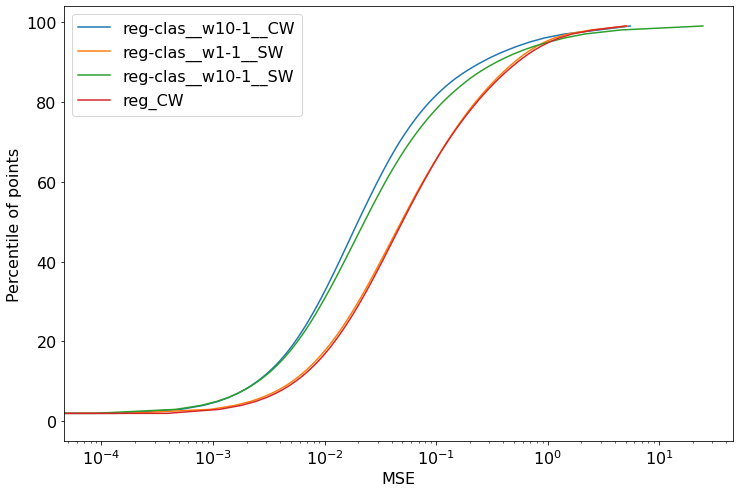

In [42]:
plt.rcParams.update({'font.size': 16})
font_size = 18

plt.figure(figsize=(12,8))
for key, value in MSE_percentiles.items():
    plt.plot(value, range(len(value)), label=key)
         
plt.legend()
plt.ylabel('Percentile of points')
plt.xlabel('MSE')
plt.xscale('log')
plt.show()

# FIGUREs C & D

In [114]:
from pose.get_pose import *
import random
random.seed(10)

def get_groundtruth_data(datapoint_file_name):
    
    data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512/"
    npz_data = np.load(data_dir + datapoint_file_name)
        
    pixel_bearing = npz_data['points_3d_sphere']
    pose = {'T': npz_data['T_blender'], 'R': npz_data['R_blender']}
    
    return pixel_bearing, pose


def filter_with_mask(coords, masks):
    masks_flat = np.reshape(masks, (-1)).astype(bool)
    coords_flat = np.reshape(coords, (-1,3))
    
    return coords_flat[masks_flat,:]


def get_pose_errors(model_dir, simple_whitenning=False):
    
    # get dataset and predictions
    dataset = load_validation_images(model_dir, simple_whitenning=simple_whitenning)
    model = load_model(model_dir)
    print('predicting...')
    pred_local_coords = predict(model, dataset['images'], dataset['masks'])
    pred_global_coords, pred_regions = unwhitten(pred_local_coords, dataset, simple_whitenning=simple_whitenning)
    pred_global_coords = np.reshape(pred_global_coords, (len(dataset['images']),256,512,3))
    
    # get validation file names
    data_partition = get_data_partition(model_dir)
    dataset_size = len(data_partition['validation'])
    
    localisation_errors = np.zeros(dataset_size)
    orientation_errors = np.zeros(dataset_size)
    
    for i, datapoint in tqdm(enumerate(data_partition['validation'])):
        datapoint_file_name = datapoint.split('/')[-1]

        # need to get GT - T and R matrices for each val image
        bearing, gt_pose = get_groundtruth_data(datapoint_file_name)
        bearing_filtered = filter_with_mask(bearing, dataset['masks'][i])
        
        # need to predict T and R matrices for each val image
        pred_global_coord_flat = np.reshape(pred_global_coords[i], (-1,3))
        pred_global_coords_filtered = filter_with_mask(pred_global_coord_flat, dataset['masks'][i])
        
        num_points = len(pred_global_coords_filtered)
        indexes = random.sample(range(num_points), int(num_points/10))
        pred_pose = get_pose_all_points(pred_global_coords_filtered[indexes], bearing_filtered[indexes], threshold=0.004)
        
        # get pose errors
        orient_error, loc_error = get_pose_error(pred_pose, gt_pose)
        
        localisation_errors[i] = loc_error
        orientation_errors[i] = orient_error
        
    return localisation_errors, orientation_errors


# Run: reg-clas, 10-1, Complex W. 

In [76]:
sorted_loc_errors = {}
sorted_orient_errors = {}

In [122]:
model_dir = "/data/cornucopia/jz522/experiments/2021-05-18/FPN_resnet_bs16_LR5e-4_w10-1_2021-05-18_11:32:32"

localisation_errors, orientation_errors = get_pose_errors(model_dir)
sorted_loc_errors['reg-clas__w10-1__CW'] = np.sort(localisation_errors)
sorted_orient_errors['reg-clas__w10-1__CW'] = np.sort(orientation_errors)

  0%|          | 0/37 [00:00<?, ?it/s]

predicting...


100%|██████████| 141/141 [00:05<00:00, 25.88it/s]
37it [01:11,  1.94s/it]


# Run: reg-clas, 1-1, Simple W. 

In [119]:
model_dir = "/data/cornucopia/jz522/experiments/2021-05-18/FPN_resnet_bs16_LR5e-4_w1-1_simple_whitenning_2021-05-18_13:33:29"

localisation_errors, orientation_errors = get_pose_errors(model_dir, simple_whitenning=True)
sorted_loc_errors['reg-clas__w1-1__SW'] = np.sort(localisation_errors)
sorted_orient_errors['reg-clas__w1-1__SW'] = np.sort(orientation_errors)

  0%|          | 0/37 [00:00<?, ?it/s]

predicting...


100%|██████████| 141/141 [00:04<00:00, 30.08it/s]
37it [01:11,  1.94s/it]


# Run: reg-clas, 10-1, Simple W. 

In [115]:
model_dir = "/data/cornucopia/jz522/experiments/2021-05-18/FPN_resnet_bs16_LR5e-4_w10-1_simple_whitenning_2021-05-18_13:32:41"

localisation_errors, orientation_errors = get_pose_errors(model_dir, simple_whitenning=True)
sorted_loc_errors['reg-clas__w10-1__SW'] = np.sort(localisation_errors)
sorted_orient_errors['reg-clas__w10-1__SW'] = np.sort(orientation_errors)

  0%|          | 0/37 [00:00<?, ?it/s]

predicting...


100%|██████████| 141/141 [00:04<00:00, 30.44it/s]
37it [01:11,  1.93s/it]


# Run: reg, 1-0, Complex W. 


In [118]:
model_dir = "/data/cornucopia/jz522/experiments/2021-05-15/fpn_resnet__bs16__LR5e-4__w11_2021-05-15_17:46:25"

localisation_errors, orientation_errors = get_pose_errors(model_dir)
sorted_loc_errors['reg_CW'] = np.sort(localisation_errors)
sorted_orient_errors['reg_CW'] = np.sort(orientation_errors)

  0%|          | 0/37 [00:00<?, ?it/s]

predicting...


100%|██████████| 138/138 [00:05<00:00, 27.57it/s]
37it [01:12,  1.96s/it]


# Plot - FIGURE C

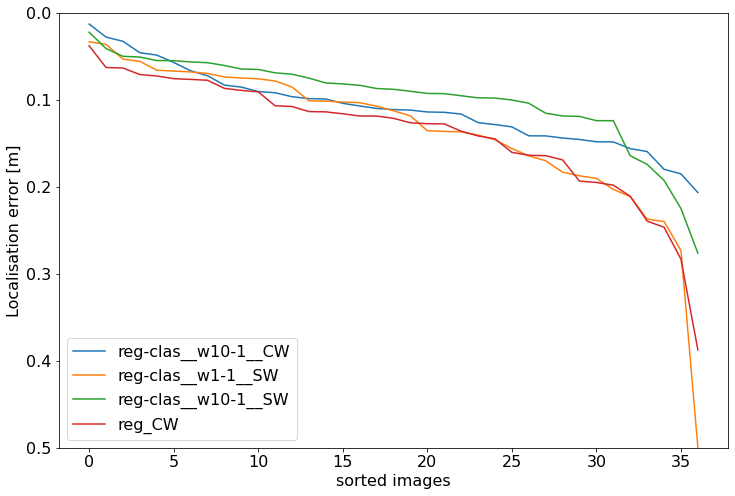

In [126]:
plt.rcParams.update({'font.size': 16})
font_size = 18

plt.figure(figsize=(12,8))
for key, value in sorted_loc_errors.items():
    plt.plot(range(len(value)), value, label=key)
         
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel('Localisation error [m]')
plt.xlabel('sorted images')
plt.ylim(0.5,0)
plt.show()

# Plot - FIGURE D

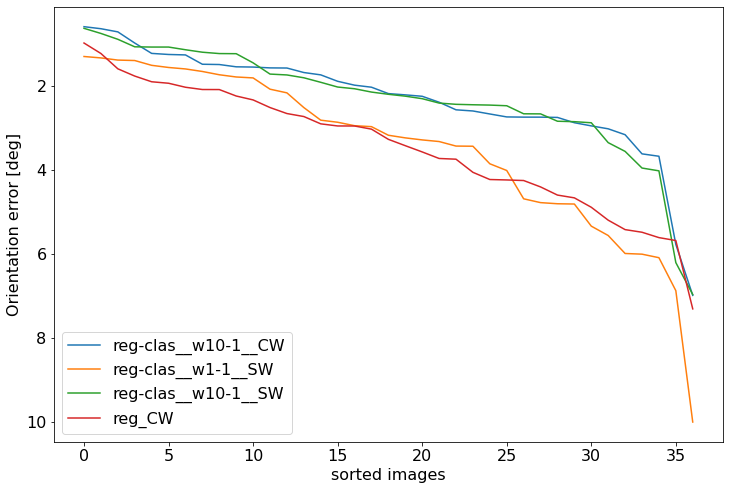

In [124]:
plt.rcParams.update({'font.size': 16})
font_size = 18

plt.figure(figsize=(12,8))
for key, value in sorted_orient_errors.items():
    plt.plot(range(len(value)), value, label=key)
         
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel('Orientation error [deg]')
plt.xlabel('sorted images')
plt.show()